# American mass shootings Map visualizer

## Objectives

*   Showcase of year by year analysis of mass shootings in United States of America
*   Detailed visualization on location of the events, victims and the approximate timeline
*   Primary purpose is to engage user with fluid visuals to comprehand severity of these fatal events and spread awareness about gun violence
*   Data source : [Mother Jones and the Foundation for National Progress](https://docs.google.com/spreadsheets/d/e/2PACX-1vQBEbQoWMn_P81DuwmlQC0_jr2sJDzkkC0mvF6WLcM53ZYXi8RMfUlunvP1B5W0jRrJvH-wc-WGjDB1/pub?gid=0&single=true&output=csv)


In [2]:
import pandas as pd
import numpy as np
import geopy as gp
from mpl_toolkits.basemap import Basemap
import matplotlib.pyplot as plt
from pylab import rcParams
import math
%matplotlib inline

In [3]:
# Reading the database
BaseData = pd.read_csv("Data/MapVisualizer/MotherJonesDataBase.csv")

# Only fetching the values that is useful for this task
BaseData = BaseData[['location','date','total_victims']]
BaseData.head()

,location,date,total_victims
0,"Smithsburg, Maryland",6/9/22,4
1,"Tulsa, Oklahoma",6/1/22,TK
2,"Uvalde, Texas",5/24/22,38
3,"Buffalo, New York",5/14/22,13
4,"Sacramento, California",2/28/22,4


In [4]:
# converting dates into dateTime format and sorting it by date
BaseData['date'] = pd.to_datetime(BaseData['date'])
BaseData = BaseData.sort_values(by="date")
BaseData.head()

,location,date,total_victims
129,"Miami, Florida",1982-08-20,11
128,"Dallas, Texas",1984-06-29,7
127,"San Ysidro, California",1984-07-18,41
126,"Edmond, Oklahoma",1986-08-20,21
125,"Palm Bay, Florida",1987-04-23,20


In [5]:

# Fetching month and year out of the date column
BaseData['year'] = pd.DatetimeIndex(BaseData['date']).year
BaseData['month'] = pd.DatetimeIndex(BaseData['date']).month
#dropping the date column
BaseData = BaseData.drop("date", axis=1)

BaseData.head()

,location,total_victims,year,month
129,"Miami, Florida",11,1982,8
128,"Dallas, Texas",7,1984,6
127,"San Ysidro, California",41,1984,7
126,"Edmond, Oklahoma",21,1986,8
125,"Palm Bay, Florida",20,1987,4


In [6]:
# Dropping rows that has any missing values
print("Shape before dropping rows with any empty value : ", BaseData.shape)
BaseData = BaseData.dropna()
print("Shape after dropping rows with any empty value : ", BaseData.shape)

# total_victim has to have all the numeric values,
BaseData['total_victims'] = pd.to_numeric(BaseData['total_victims'], downcast='signed', errors = 'coerce')
# location has to have all the string values,
BaseData['location'] = BaseData['location'].astype("string")
# any row that has NAN remove that
print("Shape before removing NAN : ", BaseData.shape)
BaseData = BaseData.dropna(subset=['location','total_victims','year','month'])
print("Shape after removing NAN : ", BaseData.shape)

BaseData.dtypes

Shape before dropping rows with any empty value :  (130, 4)
Shape after dropping rows with any empty value :  (130, 4)
Shape before removing NAN :  (130, 4)
Shape after removing NAN :  (129, 4)


location          string
total_victims    float64
year               int64
month              int64
dtype: object

In [8]:
# Setting up application to find lattitude and longitude of various places
# I am using openStreetMap data with Nominatim geocoder
geolocator = gp.Nominatim(user_agent="AA_Map_Visualizer.ipynb")
location = geolocator.geocode("Dallas, Texas")
print(location.latitude, location.longitude)
BaseData.dtypes

# since we will be doing repeated calls to nominatim, we need to use limiter to slow it down to avoid errors.
from geopy.extra.rate_limiter import RateLimiter
geocode = RateLimiter(geolocator.geocode, min_delay_seconds=1)

32.7762719 -96.7968559


In [9]:
# now let's use this geolocator to fetch latitude and longitude for all the cities we want to plot on the graph
BaseData['LocationObj'] = BaseData['location'].apply(geocode)
BaseData.head()

RateLimiter caught an error, retrying (0/2 tries). Called with (*('San Jose, California',), **{}).
Traceback (most recent call last):
  File "c:\Users\chira\AppData\Local\Programs\Python\Python39\lib\site-packages\urllib3\connectionpool.py", line 445, in _make_request
    six.raise_from(e, None)
  File "<string>", line 3, in raise_from
  File "c:\Users\chira\AppData\Local\Programs\Python\Python39\lib\site-packages\urllib3\connectionpool.py", line 440, in _make_request
    httplib_response = conn.getresponse()
  File "c:\Users\chira\AppData\Local\Programs\Python\Python39\lib\http\client.py", line 1349, in getresponse
    response.begin()
  File "c:\Users\chira\AppData\Local\Programs\Python\Python39\lib\http\client.py", line 316, in begin
    version, status, reason = self._read_status()
  File "c:\Users\chira\AppData\Local\Programs\Python\Python39\lib\http\client.py", line 277, in _read_status
    line = str(self.fp.readline(_MAXLINE + 1), "iso-8859-1")
  File "c:\Users\chira\AppData\Lo

,location,total_victims,year,month,LocationObj
129,"Miami, Florida",11.0,1982,8,"(Miami, Miami-Dade County, Florida, 33131, Uni..."
128,"Dallas, Texas",7.0,1984,6,"(Dallas, Dallas County, Texas, United States, ..."
127,"San Ysidro, California",41.0,1984,7,"(San Ysidro, San Diego, San Diego County, Cali..."
126,"Edmond, Oklahoma",21.0,1986,8,"(Edmond, Oklahoma County, Oklahoma, 73083, Uni..."
125,"Palm Bay, Florida",20.0,1987,4,"(Palm Bay, Brevard County, Florida, United Sta..."


In [10]:
# Load latitude and longitude using LocationObj returned by Geocoder
# See if the object type is of None, then just o/p NAN
BaseData['latitude'] = BaseData['LocationObj'].apply(lambda x : x.latitude if x != None else np.NAN)
BaseData['longitude'] = BaseData['LocationObj'].apply(lambda x : x.longitude if x != None else np.NAN)

# we don't need LocationObj anymore so remove it
BaseData.drop('LocationObj', axis=1)
print("Shape before removing NAN : ", BaseData.shape)
# Remove any row that has NAN values
BaseData.dropna(subset=['latitude', 'longitude'])
print("Shape before removing NAN : ", BaseData.shape)

BaseData.head()

Shape before removing NAN :  (129, 7)
Shape before removing NAN :  (129, 7)


,location,total_victims,year,month,LocationObj,latitude,longitude
129,"Miami, Florida",11.0,1982,8,"(Miami, Miami-Dade County, Florida, 33131, Uni...",25.774173,-80.193620
128,"Dallas, Texas",7.0,1984,6,"(Dallas, Dallas County, Texas, United States, ...",32.776272,-96.796856
127,"San Ysidro, California",41.0,1984,7,"(San Ysidro, San Diego, San Diego County, Cali...",32.552001,-117.043081
126,"Edmond, Oklahoma",21.0,1986,8,"(Edmond, Oklahoma County, Oklahoma, 73083, Uni...",35.657137,-97.464904
125,"Palm Bay, Florida",20.0,1987,4,"(Palm Bay, Brevard County, Florida, United Sta...",27.994697,-80.636614


In [13]:
BaseData['total_victims'] = BaseData['total_victims'].astype(np.int16)
BaseData['total_victims']

129    11
128     7
127    41
126    21
125    20
       ..
5      11
4       4
3      13
2      38
0       4
Name: total_victims, Length: 129, dtype: int16

MovieWriter writervideo unavailable; using Pillow instead.


ValueError: unknown file extension: .mp4

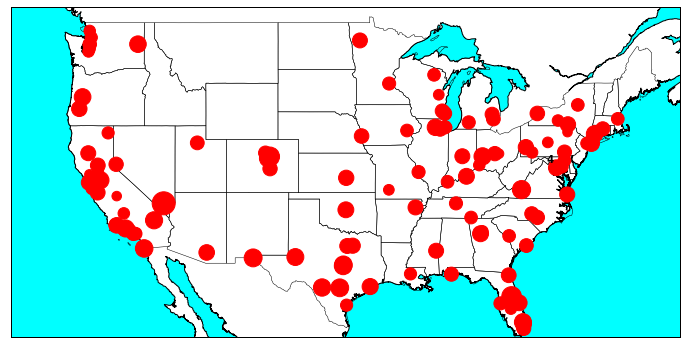

In [33]:
# setting up a map of the usa
from mpl_toolkits.basemap import Basemap as bmp
# useful to generate animation
import matplotlib.animation as animation

mapVisualizer = plt.figure(figsize=(12,12))
# Usa coordinates
llon=-130 # lower left hand map corner longitude
ulon=-65 # Upper right hand map corner longitude
llat=25
ulat=50

# creating a USA map
mp = bmp(projection='merc',resolution='i', area_thresh=100000 ,lon_0 = 0, lat_0 =90  ,llcrnrlon = llon, llcrnrlat = llat, urcrnrlon = ulon, urcrnrlat = ulat) 
# filling up land and water with different color to show boundaries and also drawing the coastlines
mp.drawmapboundary(fill_color='aqua')
mp.fillcontinents(color='white')
mp.drawcoastlines()
# drawing the boundaries of the states
mp.readshapefile('Data/MapVisualizer/USAShapeFile', 'States')

# gathering data to be plotted on the map in terms of longitude and latitude of the place where MS event took place
BaseData['ProcLons'], BaseData['ProcLats'] = mp(list(BaseData['longitude'].values), list(BaseData['latitude'].values))
BaseData.dropna(subset=['ProcLons', 'ProcLats'])
lons = list(BaseData['ProcLons'].values)
lats = list(BaseData['ProcLats'].values)
victims = list(BaseData['total_victims'].values)
FRAMES = len(lons)

# generating sizes based on the fatalities
stdSizes = (np.log(BaseData['total_victims']))*50000/BaseData['total_victims'].max()
myscat = mp.scatter([], [], marker='o', color='r',zorder = 5)

AnnotationList = []
def update(i):
    if(len(AnnotationList) > 0):
        AnnotationList[0].remove() #removing annotation
        AnnotationList[:] = []
    x = lons[:i]
    y = lats[:i]
    myscat.set_offsets(np.c_[x,y])
    myscat.set_sizes(stdSizes[:i])
    ann = plt.annotate(victims[i], xy=(lons[i], lats[i]), xytext = (lons[i]-50000, lats[i]-50000),weight='bold', color='black',zorder = 10)
    AnnotationList.append(ann)
    return myscat,

anim = animation.FuncAnimation(plt.gcf(), update, frames = FRAMES, interval=100000, blit=True)
anim.save('Results/AMSExample.mp4', writer='writervideo', fps=60)
plt.show()

# possibly increase the size of numbers and dots
# overlap problem
# vdo conversion problem
# border around marker if possible
# animate location
# animate total number of victims